In [1]:
# imports
import sys
import pandas as pd
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import core_exp as cx
import core_calib as cal


import Data.data_provider as dp
from estimators.IR_RF_estimator import IR_RF
from sklearn.model_selection import RandomizedSearchCV


In [2]:
params = cx.params_all.copy()
params["hyper_opt"] = False
exp_key = "depth"
exp_values = [1,2]



In [10]:
calib_results_dict, data_list = cx.run_exp(exp_key, exp_values, params)

data 6
data 6
data 6
data 6


In [4]:
data_list = []
calib_results_dict = {}

for exp_param in exp_values: 
    params[exp_key] = exp_param
    # Data
    exp_data_name = str(exp_param) # data_name + "_" + 
    data_list.append(exp_data_name)
    X, y, tp = dp.make_classification_gaussian_with_true_prob(params["data_size"], params["n_features"], 
                                                          class1_mean_min=0, 
                                                          class1_mean_max=1,

                                                          class2_mean_min=1, 
                                                          class2_mean_max=3, 

                                                          seed=0)

    # X, y = dp.load_data(data_name, "../../")

    data_dict = {} # results for each data set will be saved in here.
    for seed in range(params["runs"]): # running the same dataset multiple times
        # split the data
        data = cal.split_train_calib_test(exp_data_name, X, y, params["test_split"], params["calib_split"], seed, tp)

        # train model - hyper opt
        search_space = {
            "n_estimators": [params["n_estimators"]],
            "max_depth": [1,2,3,4,5,6,7,8],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [2,3,4,5],
            "min_samples_leaf": [1,2,3],
        }
        rf = IR_RF(random_state=seed)

        # RS = RandomizedSearchCV(rf, search_space, scoring=["accuracy"], refit="accuracy", cv=params["opt_cv"], n_iter=params["opt_n_iter"], random_state=seed)
        # RS.fit(data["x_train"], data["y_train"])
        # rf_best = RS.best_estimator_

        # train model
        rf_best = IR_RF(n_estimators=params["n_estimators"], oob_score=params["oob"], max_depth=params["depth"], random_state=seed)
        rf_best.fit(data["x_train"], data["y_train"])

        # calibration
        res = cal.calibration(rf_best, data, params) # res is a dict with all the metrics results as well as RF probs and every calibration method decision for every test data point
        data_dict = cal.update_runs(data_dict, res) # calib results for every run for the same dataset is aggregated in data_dict (ex. acc of every run as an array)
        if True:
            cal.plot_probs(exp_data_name, res, data, params["calib_methods"], seed, "RF", False, True) 

    calib_results_dict.update(data_dict) # merge results of all datasets together
    


data 6
data 6
data 6
data 6


In [5]:
tables = cal.mean_and_ranking_table(calib_results_dict, params["metrics"], params["calib_methods"], data_list, mean_and_rank=False, std=True)

In [6]:
plot_calib_methods = params["calib_methods"].copy()
# plot_calib_methods.remove("Rank")
# plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF', 'Platt']

In [7]:
tables["tce"]

,RF,Platt
Data,,
1,0.118245,0.075714
2,0.098144,0.050699


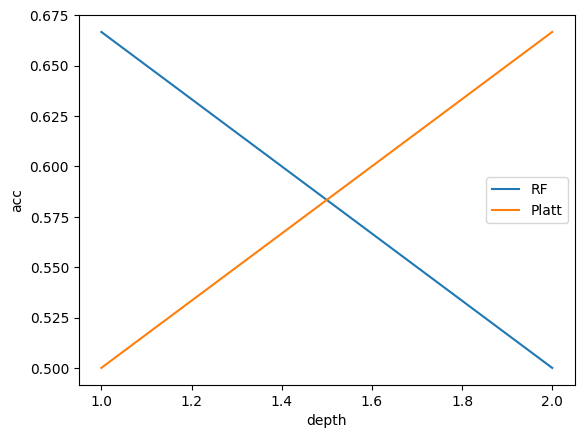

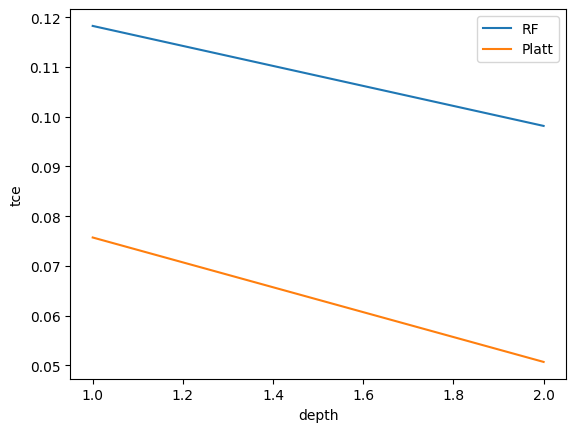

In [8]:
for metric in params["metrics"]:
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel(exp_key)
    ax.set_ylabel(metric)

In [9]:


# # params
# calib_methods = ["RF", "Platt"]
# metrics = ["acc", "tce"]

# data_name = "S_RFdepth"
# # data_name = "spambase"
# plot = True

# params = {
#     # exp
#     "runs": 1,
#     "plot": True,
#     "calib_methods": ["RF", "Platt"], # , "ISO", "Rank", "CRF", "VA", "Beta", "Elkan", "tlr", "Line"],
#     "metrics": ["acc", "tce"], #"auc", "brier", "logloss", "ece", "tce"],
    
#     #data
#     "data_size": 1000,
#     "n_features": 2,

#     "class1_mean_min":0, 
#     "class1_mean_max":1,
#     "class2_mean_min":1, 
#     "class2_mean_max":3, 

#     "test_split": 0.3,
#     "calib_split": 0.1,


#     # calib param
#     "ece_bins": 30,
#     "boot_size": 20,
#     "boot_count": 10,

#     # RF hyper opt
#     "hyper_opt": False,
#     "opt_cv":5, 
#     "opt_n_iter":10,
#     "search_space": {
#                     "n_estimators": [10],
#                     "max_depth": [1,2,3,4,5,6,7,8],
#                     "criterion": ["gini", "entropy"],
#                     "min_samples_split": [2,3,4,5],
#                     "min_samples_leaf": [1,2,3],
#                     },
#     # RF
#     "depth": 6,
#     "n_estimators": 10,
#     "oob": False,

# }

# exp_key = "depth"
# exp_values = [1,2,3,4,5,6,7,8,9,10]